# Employee Attrition Analysis

# 🔧Step 1: Importing necessary libraries

In [1]:
!pip install shap --quiet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings('ignore')

# 📁 Step 2: Upload/Mount dataset


Option A: Use if you are uploading manually

In [3]:
from google.colab import files

print("Please upload 'HR_Analytics.csv'")
uploaded = files.upload()

df = pd.read_csv('HR_Analytics.csv')

Please upload 'HR_Analytics.csv'


Saving HR_Analytics.csv to HR_Analytics.csv


Option B: Mount Google Drive (If you have the file in Google Drive)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/HR_Analytics.csv')  # Update path accordingly

# 🧹 Step 3: Data Inspection & Cleaning

In [5]:
# Drop irrelevant columns
df.drop(columns=["EmpID", "EmployeeCount", "StandardHours", "EmployeeNumber", "Over18"], inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Convert target column to binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [8]:
df.head()

,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,18,0,1,3,230,1,3,3,1,3,...,3,3,0,0,2,3,0,0,0,0.0
1,18,0,0,3,812,2,10,3,3,4,...,3,1,0,0,2,3,0,0,0,0.0
2,18,0,1,2,1306,2,5,3,2,2,...,3,4,0,0,3,3,0,0,0,0.0
3,18,0,0,0,287,1,5,2,1,2,...,3,4,0,0,2,3,0,0,0,0.0
4,18,0,1,0,247,1,8,1,3,3,...,3,4,0,0,0,3,0,0,0,0.0


In [10]:
df.describe()

,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,36.924807,1.639494,0.161630,2.488405,802.000000,1.263528,9.262825,2.907238,2.250878,2.726634,...,3.151089,2.701335,0.797611,11.302881,2.799719,2.761771,7.042164,4.255095,2.211525,4.118060
std,9.133367,0.945810,0.368241,0.940404,404.008071,0.530489,8.146760,1.023547,1.334239,1.089736,...,0.358262,1.081122,0.850958,7.819449,1.288246,0.710698,6.147705,3.631051,3.248210,3.555484
min,18.000000,0.000000,0.000000,0.000000,102.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,1.000000,0.000000,2.000000,465.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,2.000000,0.000000,3.000000,802.000000,1.000000,7.000000,3.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,2.000000,0.000000,3.000000,1157.000000,2.000000,14.000000,4.000000,3.000000,4.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,4.000000,1.000000,3.000000,1499.000000,2.000000,29.000000,5.000000,5.000000,4.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


# 🔢 Step 4: Encode Categorical Features

In [6]:
# Label encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 📊 Step 5: Exploratory Data Analysis (EDA)

Attrition By Department

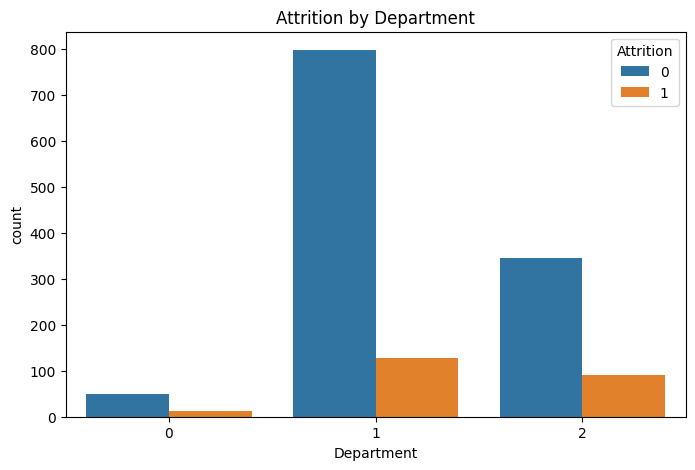

In [11]:

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title('Attrition by Department')
plt.show()


Income vs Attrition

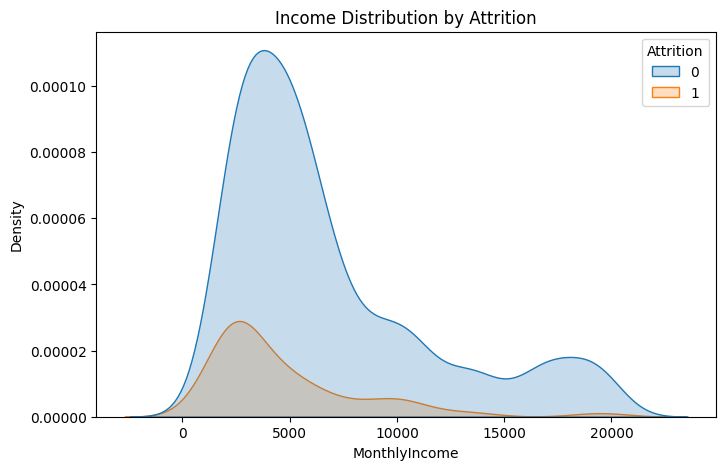

In [12]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='MonthlyIncome', hue='Attrition', fill=True)
plt.title('Income Distribution by Attrition')
plt.show()


Years Since Last Promotion vs Attrition

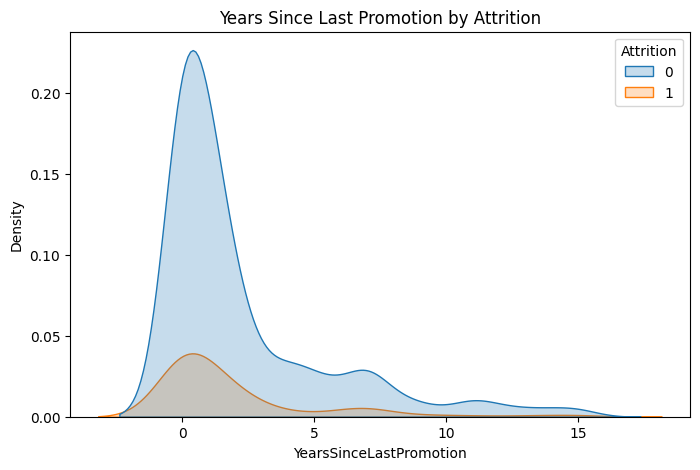

In [13]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='YearsSinceLastPromotion', hue='Attrition', fill=True)
plt.title('Years Since Last Promotion by Attrition')
plt.show()

# ⚙️ Step 6: Prepare Train/Test Split

In [14]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 💾 Step 7: Feature Scaling (Optional for Tree-based Models)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#🌲 Step 8: Handle Class Imbalance with SMOTE


In [16]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# 🧠 Step 9: Train Model with Cross-Validation


In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='recall')
print(f"Average Recall (Cross-Validation): {cv_scores.mean():.2f}")

# Fit on full resampled training set
model.fit(X_resampled, y_resampled)

Average Recall (Cross-Validation): 0.91


RandomForestClassifier(class_weight='balanced', random_state=42)

# 📈 Step 10: Evaluate Model

In [18]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.8631578947368421

Confusion Matrix:
 [[236   3]
 [ 36  10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       239
           1       0.77      0.22      0.34        46

    accuracy                           0.86       285
   macro avg       0.82      0.60      0.63       285
weighted avg       0.85      0.86      0.83       285


ROC AUC Score: 0.7712843369110424


# 🔍 Step 11: SHAP Explainability

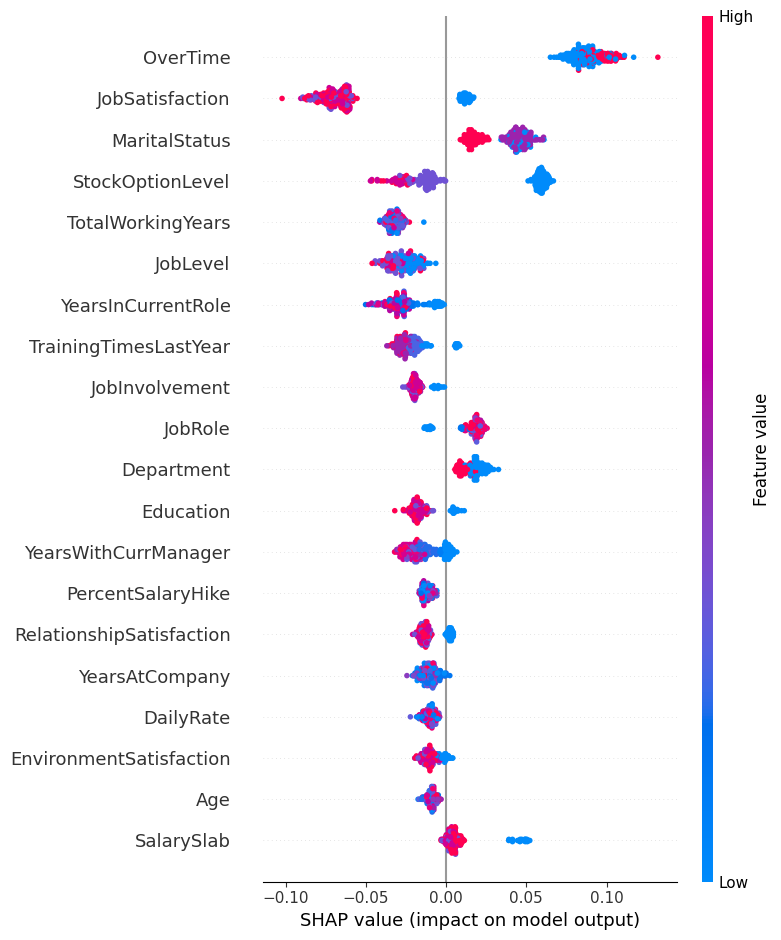

In [24]:
# SHAP explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values[:,:,1], X_test)

# 💾 Step 12: Save Model and Scaler

In [25]:
# Save model
joblib.dump(model, 'attrition_model.pkl')

# Save scaler
joblib.dump(scaler, 'feature_scaler.pkl')

['feature_scaler.pkl']

# 🧪 Step 13: Example of Reusing the Saved Model

This section demonstrates how the saved model can be reloaded and used to make predictions on new data, which is essential for deployment in HR systems or dashboards like Power BI.

In [26]:
# Load saved model and scaler
loaded_model = joblib.load('attrition_model.pkl')
loaded_scaler = joblib.load('feature_scaler.pkl')

# Example prediction
example = X_test.iloc[[0]]  # First row from test set
scaled_example = loaded_scaler.transform(example)
prediction = loaded_model.predict(scaled_example)
probability = loaded_model.predict_proba(scaled_example)[0][1]

print(f"Predicted Attrition: {prediction[0]}")
print(f"Probability of Attrition: {probability:.2f}")

Predicted Attrition: 0
Probability of Attrition: 0.23
